<a href="https://colab.research.google.com/github/mikeacb/imageClassifier/blob/master/ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* TensorFlow es una librería de computo matemático que facilita el entrenamiento de las redes neuronales.
* TensorFlow_dataset nos permite incluir uno de los datasets con los que cuenta la página oficial de TensorFlow.
* Mathplotlib es una librería de generación de gráficos a partir de datos contenidos en listas o arrays en Python. En este caso, usaremos dos de sus derivados por así decirlo, una es pyplot, que nos provee de un framework de gráficos parecidos a MATLAB. La otra es Numpy que da soporte para vectores y matrices de grandes multidimensiones, junto con una gran colección de funciones matemáticas de alto nivel para operar con ellas.
* Y math, que proporciona acceso a las funciones matemátcias definidas en el estándar de C. Estas funciones no pueden ser usadas con números complejo.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import math as m
import numpy as np

Se descarga el dataset en conjunto con sus metadatos, esto último para revisar el tamaño de las imágenes, si son en blanco y negro o a color, el número de clases o tipos de imágenes que nos encontraremos, el total de imágnes de prueba y entrenamiento con las que contamos y el respectivo nombre de esos folders.

In [ ]:
datos, metadatos = tfds.load('rock_paper_scissors', as_supervised=True, with_info=True)
metadatos

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

Se separan el conjunto de datos (train y test) en variables para usarlas en las pruebas.
Guardamos el nombre de las categorías que contiene nuestro dataset.
Se muestran los nombres y como índices tenemos del 0-2, o sea, 3 tipos

In [ ]:
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']
nombre_clases = metadatos.features['label'].names
nombre_clases

['rock', 'paper', 'scissors']

Se normalizan los datos en una función que creamos (ya que actualmente se reciben de 0-255, ya que es el valor que puede tener cada pixel de la imágen, asi que lo dividimos entre 255) para que todas las entradas sean entre 0 y 1, esto ayuda a mejorar el rendimiento y acelarar los resultados.

Se normalizan los datos de entrenamiento y también los de pruebas con la función que ya hicimos.

Y por último, agregamos los datos de entrenamiento y pruebas a caché, esto eso porque usar la memoria chaché en lugar de disco hace que el entrenamiento sea más rápido.

In [ ]:
def normalizar (imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255
  return imagenes, etiquetas
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()


Lo siguiente no tiene nada que ver con la red neuronal, solo es para mostrar o dibujar en pantalla una imagen de los datos de entrenamiento y esta tiene una dimensión de 300x300 pixeles. También podemos mostrar las categorías con sus respectivas imágenes con las que cuenta nuestro dataset.

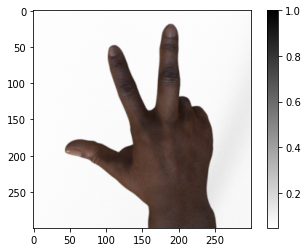

In [ ]:
for imagen, etiqueta in datos_entrenamiento.take(5):
  break
imagen = imagen.numpy().reshape((300, 300, 3))
plt.figure()
plt.imshow(imagen, cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

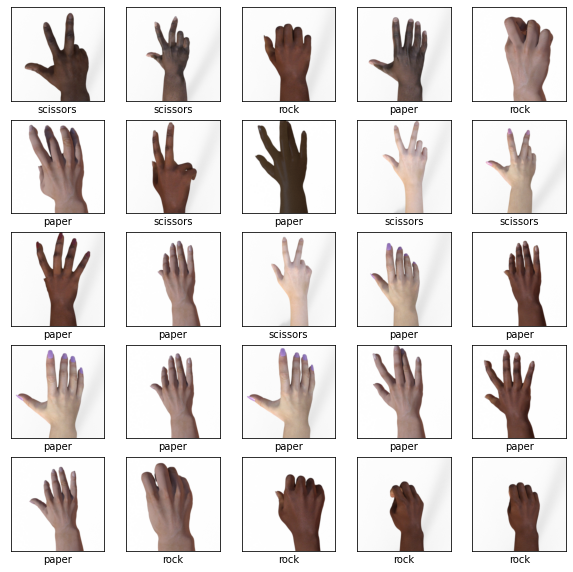

In [ ]:
plt.figure(figsize=(10, 10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((300, 300, 3))
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap= plt.cm.binary)
  plt.xlabel(nombre_clases[etiqueta])
plt.show()

Después pasamos con la creación del modelo, y hacemos uso de la función sequential(), que crea una red neuronal vacía a la que habrá que argegar las capas correspondientes (entrada, las densas o escondidas y la de salida), en una red secuencial los datos alimentan a la primera capa oculta y son procesados capa por capa (hacia adelante) hasta la capa de salida.

Se define la capa de entrada como tipo flatten, la capa flatten se encarga de convertir la matríz y "aplastar" a una sola dimensión con 90,000 nauronas (300x300 pixeles) en donde se recibirá cada pixel.

Las siguientes son dos capas densas con 50 neuronas cada una con la función de activación Relu. Las capas ocultas recogen la entrada de la capa anterior y generan la salida para la siguiente capa y la función de activación se encarga de devolver una salida a partir de un valor de entrada, normalmente el conjunto de valores de slida en un rango determinado como (0, 1) o (-1, 1). Se busca funciones que las derivadas sean simples, para minimizar el coste computacional.

Existen diferentes tipos de funciones de activación, tales como:

- La función de activación ReLU, que transforma los valores introducidos anulando los valores negativos y dejando los positivos tal cual como entran.
- La sigmoide, que transforma los valores introducidos a una escala (0, 1), donde los valores altos tienen de manera asintótica a 1 y los valores muy bajos tienden de manera asintótica a 0.
- La tangente hiperbólica, que transforma los valores a una escala (-1, 1), donde los valores altos tienen de manera asintótica a 1 y los valores muy bajos tienden de manera asintótica a -1.
- Y por último la función softmax, que transforma las salidas a una representación en forma de probabilidades, de tal manera que la sumatoria de todas las probabilidades de las salidas de 1.

La capa de slida hace uso de la función softmax en las redes de clasificación para asegurar que la suma de las neuronas siempre nos de 1.

Ejemplo, si la red cree que la imagen son tijeras, tijeras puede tener .7 de probabilidad, papel .2 y piedra .1, y así la suma de la anterior nos da 1 al final solo vemos cual es el mayor de todos y esa es la predicción de la red.

In [ ]:
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(300, 300, 3)),
  tf.keras.layers.Dense(50, activation= tf.nn.relu),
  tf.keras.layers.Dense(50, activation= tf.nn.relu),
  tf.keras.layers.Dense(10, activation= tf.nn.softmax)
])

Antes de pasar al proceso de entrenamiento de la red, es necesario definir los parámetros de entrenamiento mediante el método compile, el cual tienen los siguientes parámetros:

* La función del optimizador es decir que tanto cambia cada parámetro dada la predicción actual. Existen varios tipos de optimizadores tales como, sdg, rmsprop, adagrad, adam, adamax, nadam, etc.
* En una función de pérdida su meta es devolver un número que indique "qué tan mal" esta la predicción del modelo. Este cálculo se realizará para cada lote de datos de entrenamientol. Existen algunas funciones predefinidas como "categoricalCrossentropy" que es la medida de entropía que permite separar o distinguir entre diferentes categorías de los datos o "meanSquaredError" que es la distancia mínima cuadrada entre los puntos que estas tratando de aprender y el punto que el modelo está tratando de predecir. Cuándo el resultado del cálculo no coincide con lo esperado la función de pérdida dirá que tan lejos estamos para que el optimizador haga su trabajo y ajuste los parámetros.
* Y la lista de métricas son para monitorear el proceso del entrenamiento, dan sólo un número que indica que tan bien lo está haciendo nuestro modelo. Se computa sobre el total de datos al final de cada época. Y se pueden incluir métricas definidas por el usuario.

El método compile no modifica en nada los parámetros en la red.

In [ ]:
modelo.compile(
  optimizer='adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

Guardamos y mostramos el número de datos de los datasets de entrenamiento y de pruebas.

In [ ]:
num_entrenamiento = metadatos.splits['train'].num_examples
num_pruebas = metadatos.splits['test'].num_examples
print(num_entrenamiento)
print(num_pruebas)

2520
372


Para que la red entrene más rápido, hacemos que lo haga en lotes de 30 imágenes (o algún otro numero divisible entre la cantidad de datos de entrenamiento). Y como se darán varias vueltas al dataset en el entrenamiento, lo que se quiere es que sea de manera aleatoria y no siempre en un mismo orden, para eso se usan las funciones repeat y shuffle, a shuffle le pasamos el número de datos de entrenamiento, con batch le decimos el tamaño del lote de entrenamiento para que lo haga más rápido y con el set de datos de pruebas solo usaremos batch para decirle el lote de entrenamiento también.

In [ ]:
lote_size = 30
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_entrenamiento).batch(lote_size)
datos_pruebas = datos_pruebas.batch(lote_size)

Para el entrenamiento usaremos la función fit, que es para modelos pequeños, en donde se deberá de definir el número de épocas (cántas veces queremos que se recorra de manera total el conjunto de datos) y el tamaño del lote, el callback, la cual es una lista de funciones a invocarse durante el entrenamiento para monitorear estados internos del modelo durante el entrenamiento y también es posible usar funciones callback definidas por nosotros, steps per epoch es el número total de pasos (lotes de muestras) para generar desde el generador antes de declarar que una época finalizó y comenzó la siguiente época. Por lo general, debe ser igual al número de muestras únicas de su conjunto de datos dividido por el tamaño del lote. Y lo que nos interesa del resultado que se nos muestra a continuación es la accurancy, que es la precisión con la que se predecirán los resultados de nuestra red.

In [ ]:
historial = modelo.fit(datos_entrenamiento, epochs= 10, steps_per_epoch=m.ceil(num_entrenamiento/lote_size))

Epoch 1/10
84/84 [==============================] - 22s 125ms/step - loss: 8.7746 - accuracy: 0.4865
Epoch 2/10
84/84 [==============================] - 9s 104ms/step - loss: 0.7732 - accuracy: 0.7278
Epoch 3/10
84/84 [==============================] - 8s 100ms/step - loss: 0.3767 - accuracy: 0.8536
Epoch 4/10
84/84 [==============================] - 8s 100ms/step - loss: 0.3095 - accuracy: 0.8933
Epoch 5/10
84/84 [==============================] - 9s 101ms/step - loss: 0.3039 - accuracy: 0.8865
Epoch 6/10
84/84 [==============================] - 8s 100ms/step - loss: 0.2191 - accuracy: 0.9218
Epoch 7/10
84/84 [==============================] - 8s 99ms/step - loss: 0.2038 - accuracy: 0.9246
Epoch 8/10
84/84 [==============================] - 8s 100ms/step - loss: 0.5979 - accuracy: 0.8552
Epoch 9/10
84/84 [==============================] - 8s 101ms/step - loss: 0.4077 - accuracy: 0.8921
Epoch 10/10
84/84 [==============================] - 9s 102ms/step - loss: 0.0722 - accuracy: 0.9754

A continuación mostramos el resultado de pérdida en cada época, en donde por cada época por la que pasamos, la pérdida va bajando hacia casi 0 y la precisión va aumentando casi a 1.

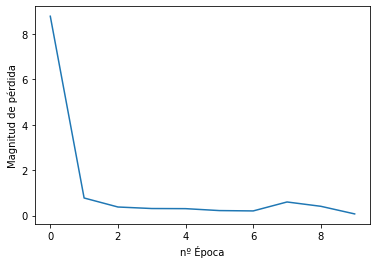

In [ ]:
plt.xlabel("nº Época")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

Y con esto terminamos el entrenamiento y compilación de nuestra red neuronal

Lo siguiente solo será mostrar, ya sea una predicción de nuestro lote de pruebas o un conjunto de imágenes con la precisión de la predicción.

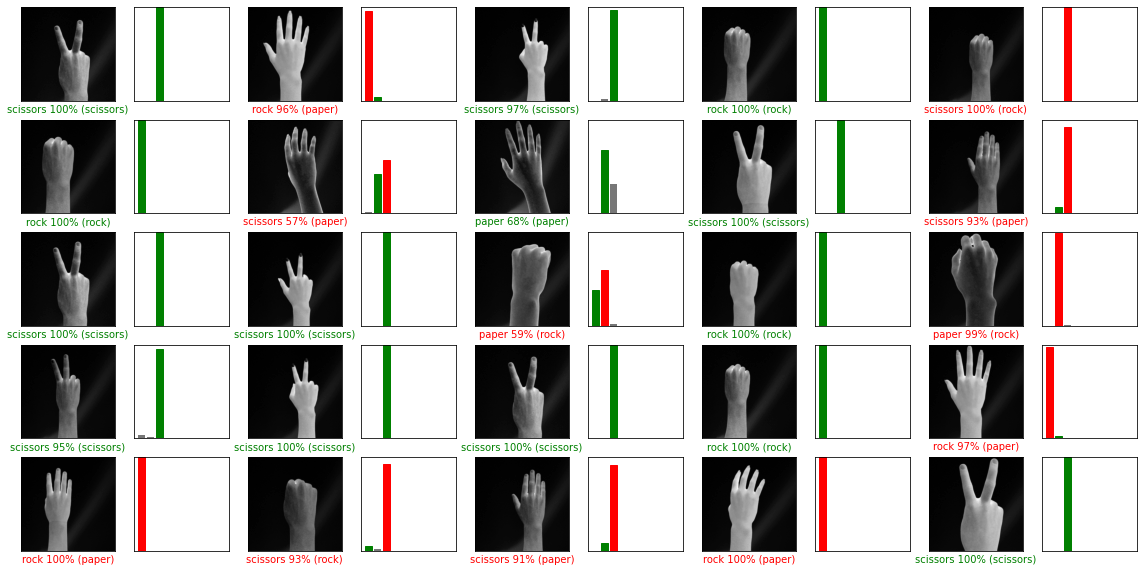

In [ ]:
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'green'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(nombre_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombre_clases[etiqueta_real]),
                                color=color)
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('green')
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [ ]:
imagen = imagenes_prueba[2]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombre_clases[np.argmax(prediccion[0])])

Prediccion: scissors


Algunas de las limitantes que tiene este tipo de red neuronal son:
- Cuando haga una prueba con una imagen evidentemente erronea para nosotros, siempre tratará de darnos una predicción en base a lo que la entrenamos.
- Tiene un punto de fallo o fragilidad, que es que si se mueven aunque sea 1px de lugar las imagenes, esta red ya no podrá reconocerlas, este es un problema que tienen las redes de regresión linea, ya que sus entradas nunca cambian, sino confundiría al algoritmo.
- Este tipo de probelmas se solucionan con redes neuronales convolucionales, ya que estas no intentan aprenderse la posición de los pixeles, sino que intenta interpretar lo que le estamos dando como entrada.